In [3]:
#import libraries.
import numpy as np
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
from tensorflow.python.keras.utils.data_utils import Sequence
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
from keras.wrappers.scikit_learn import KerasRegressor
import keras
from keras import regularizers
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from keras.initializers import glorot_normal
# import sounddevice as sd
import tensorflow as tf
from mir_eval import separation 
from pystoi.stoi import stoi 
import h5py
from keras.callbacks import LearningRateScheduler
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
import math
from sklearn.utils import shuffle
from sklearn import preprocessing
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
#import libraries.
# import matplotlib.pyplot as plt
# from tabulate import tabulate
import time
import os
import librosa
from librosa.core import stft, istft
import time
import pickle
from keras import backend as K
from tensorflow.keras.models import load_model
# from keras.models import load_model

In [5]:
def loss_DNNC(y_true, y_pred, Lambda = 0.05):
    loss = K.sum(K.square(y_true - y_pred)) 
    - Lambda * K.sum(K.square(y_true[0:257,:] - y_pred[0:257,:]) + K.square(y_true[257:,:] - y_pred[257:,:]))
    return loss

In [6]:
def reconstruct(wave,angle):
    recon1 = wave*np.cos(angle)+wave*np.sin(angle)*1j
#     recon = np.sqrt(np.power(10, wave))
#     recon1 = recon*np.cos(angle)+recon*np.sin(angle)*1j
    recon = librosa.core.istft((recon1.T), hop_length=160, win_length=400, window='hann')
    return recon

In [55]:
data_series = str(4)

In [56]:
h5f = h5py.File('TIMIT/Organized/Two_stage_sec_set/predicted_sec_set.hdf5','r')
X = h5f['predicted_sec_set'][:]
h5f.close()
print(X.shape)

(514, 295522)


In [57]:
h5f = h5py.File('TIMIT/Organized/concatenated/clean'  + data_series + '_sec.hdf5','r')
y = h5f['clean'  + data_series + '_sec'][:]
h5f.close()
print(y.shape)

(514, 295522)


In [58]:
h5f = h5py.File('TIMIT/Organized/concatenated/valid_mixed'  + data_series + '.hdf5','r')
X_valid = h5f['valid_mixed'  + data_series ][:]
h5f.close()
print(X_valid.shape)

(55383, 257)


In [59]:
h5f = h5py.File('TIMIT/Organized/concatenated/valid_clean'  + data_series + '.hdf5','r')
y_valid = h5f['valid_clean'  + data_series ][:]
h5f.close()
print(y_valid.shape)

(55383, 514)


In [12]:
np.linalg.norm(X[:,0])

0.121167555

In [60]:
X_train = preprocessing.normalize(X, norm='l2', axis=0, copy=True)
y_train = preprocessing.normalize(y, norm='l2', axis=0, copy=True)

In [61]:
X_valid = preprocessing.normalize(X_valid, norm='l2', axis=0, copy=True)

In [62]:
estimator_A = load_model('Models/Two_stage/trained_model19.h5')
prediction = estimator_A.predict(X_valid)
prediction0 = np.multiply(X_valid, prediction[:,0:257])
prediction1 = np.multiply(X_valid, prediction[:,257:])
X_valid = np.concatenate((prediction0, prediction1), axis=1)

In [63]:
X_valid = preprocessing.normalize(X_valid, norm='l2', axis=0, copy=True)
y_valid = preprocessing.normalize(y_valid, norm='l2', axis=0, copy=True)

In [64]:
print(X.shape)
print(y.shape)
print(X_valid.shape)
print(X_valid.shape)


(514, 295522)
(514, 295522)
(55383, 514)
(55383, 514)


In [68]:
X_dim= 514
y_dim = 514
h_C = [1028, 1028, 1028]
def DNN_C():
    # create model
    model = Sequential()
    model.add(Dense(h_C[0], input_dim = X_dim, kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Activation('sigmoid'))
    
    model.add(Dense(h_C[1], kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Activation('sigmoid'))
    
    model.add(Dense(h_C[2], kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Activation('sigmoid'))
    
    model.add(Dense(y_dim, kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Activation('sigmoid'))
    # Compile model
    model.compile(loss=loss_DNNC, optimizer='adam')
    return model

In [71]:
batch_size = 100
tic = time.time()
estimator_C = KerasRegressor(build_fn=DNN_C, epochs = 200, batch_size=batch_size, shuffle = True, verbose=1)
# kfold = KFold(n_splits=2, random_state=None)
# kfold = KFold(n_splits=5)
# results = cross_val_score(estimator_A, X.T, y.T, cv=kfold)
# print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))
# toc_fold = time.time()

print("^^^^^^^^^^^^^^^^^^^^^ Training on mixed5^^^^^^^^^^^^^^^^^^^^^")
# filepath="half_trained.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor = 'loss', verbose = 0, save_best_only = True, mode = 'min') 
# callbacks_list = [checkpoint]
history = estimator_C.fit(X.T, y.T, validation_data=(X_valid, y_valid), shuffle = True, batch_size=batch_size,  steps_per_epoch=None)
toc_adam = time.time()
# print("---------------------------second part of training---------------------------")
# new_model = load_model(filepath)
# checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save?_best_only=True, mode='min')
# callbacks_list = [checkpoint]
# new_model.optimizer = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
# new_model.fit(X.T, Mask.T, shuffle = True, epochs = 100, batch_size=100,  steps_per_epoch=None, callbacks=callbacks_list)
# estimator_A.fit (X.T, y.T, shuffle = True, batch_size=100,  steps_per_epoch=None, callbacks = [changer])
# prediction = estimator_A.predict(X_test)

toc_fit = time.time()

^^^^^^^^^^^^^^^^^^^^^ Training on mixed5^^^^^^^^^^^^^^^^^^^^^
Train on 295522 samples, validate on 55383 samples
Epoch 1/200
295522/295522 [==============================] - 26s 88us/step - loss: 5380.3147 - val_loss: 1268.3572
Epoch 2/200
295522/295522 [==============================] - 26s 87us/step - loss: 1738.0682 - val_loss: 178.6418
Epoch 3/200
295522/295522 [==============================] - 25s 86us/step - loss: 1497.9548 - val_loss: 67.3805
Epoch 4/200
295522/295522 [==============================] - 24s 81us/step - loss: 1458.3881 - val_loss: 77.9630
Epoch 5/200
295522/295522 [==============================] - 24s 82us/step - loss: 1438.8661 - val_loss: 73.1857
Epoch 6/200
295522/295522 [==============================] - 24s 81us/step - loss: 1426.8275 - val_loss: 70.0564
Epoch 7/200
295522/295522 [==============================] - 25s 84us/step - loss: 1417.4443 - val_loss: 94.8682
Epoch 8/200
295522/295522 [==============================] - 25s 85us/step - loss: 1410.3849 

295522/295522 [==============================] - 25s 83us/step - loss: 1191.7685 - val_loss: 147.3500
Epoch 143/200
295522/295522 [==============================] - 24s 83us/step - loss: 1191.4238 - val_loss: 83.0429
Epoch 144/200
295522/295522 [==============================] - 25s 83us/step - loss: 1190.6132 - val_loss: 72.6543
Epoch 145/200
295522/295522 [==============================] - 25s 83us/step - loss: 1189.6052 - val_loss: 394.0444
Epoch 146/200
295522/295522 [==============================] - 25s 86us/step - loss: 1189.3451 - val_loss: 128.2043
Epoch 147/200
295522/295522 [==============================] - 25s 83us/step - loss: 1188.5902 - val_loss: 348.3904
Epoch 148/200
295522/295522 [==============================] - 24s 83us/step - loss: 1187.4650 - val_loss: 172.8352
Epoch 149/200
295522/295522 [==============================] - 25s 84us/step - loss: 1187.2429 - val_loss: 232.4129
Epoch 150/200
295522/295522 [==============================] - 25s 86us/step - loss: 118

In [72]:
estimator_C.model.save('Models/Two_stage/Model0_C0.h5')

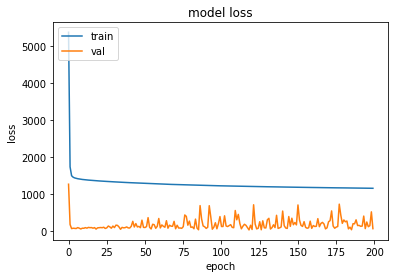

In [73]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [74]:
print('Time= ', (toc_fit - tic)/60)

Time=  82.56514866749446


In [8]:
data_series = str(4)
test_point_start0 = 0
test_point_stop0 = 1000

In [9]:
h5f = h5py.File('TIMIT/Organized/Two_stage_sec_set/predicted_sec_set.hdf5','r')
test_input = h5f['predicted_sec_set'][:, test_point_start0 : test_point_stop0]
h5f.close()
print(test_input.shape)
h5f = h5py.File('TIMIT/Organized/concatenated/phase' + data_series + '_sec.hdf5','r')
angle_mixed = h5f['phase' + data_series + '_sec'][:, test_point_start0 : test_point_stop0]
h5f.close()
print(angle_mixed.shape)
h5f = h5py.File('TIMIT/Organized/concatenated/clean' + data_series + '_sec.hdf5','r')
test_target = h5f['clean' + data_series + '_sec'][:, test_point_start0 : test_point_stop0]
h5f.close()
print(test_target.shape)
h5f = h5py.File('TIMIT/Organized/concatenated/phase' + data_series + '_sec.hdf5','r')
angle_clean = h5f['phase' + data_series + '_sec'][:, test_point_start0 : test_point_stop0]
h5f.close()
print(angle_clean.shape)

(514, 1000)
(257, 1000)
(514, 1000)
(257, 1000)


In [10]:
test_input = preprocessing.normalize(test_input, norm='l2', axis=0, copy=True)

In [11]:
np.linalg.norm(test_input[:,0])

1.0

In [12]:
prediction = estimator_C.predict(test_input.T)

NameError: name 'estimator_C' is not defined